# 回帰手法の比較と使い分け (OLS / Ridge / Lasso / Elastic Net / AIC)

本ノートブックでは、線形回帰の基本手法である **OLS (Ordinary Least Squares)** と、過学習を防ぐための正則化手法である **Ridge**, **Lasso**, **Elastic Net** を比較します。また、モデル選択の指標として用いられる **AIC (Akaike Information Criterion)** についても解説します。

## 1. 手法の概要と使い分け

| 手法 | 正則化項 (ペナルティ) | 特徴 | 典型的な用途 |
|---|---|---|---|
| **OLS (最小二乗法)** | なし | 最も基本的。バイアスはないが、バリアンスが大きくなりやすく過学習しやすい。 | データ数が多く、特徴量が少ない単純なケース。 |
| **Ridge (L2正則化)** | $\alpha \sum w_i^2$ | 係数の大きさを抑制する。係数は0にはならない。多重共線性（マルチコ）に強い。 | 特徴量間に相関がある場合。過学習を抑えたいが、変数は減らしたくない場合。 |
| **Lasso (L1正則化)** | $\alpha \sum |w_i|$ | 係数を0にしやすい（疎な解）。不要な特徴量を自動的に削除する効果がある。 | 特徴量が多く、重要な変数が少数であると予想される場合（特徴量選択）。 |
| **Elastic Net** | L1 + L2 | LassoとRidgeのハイブリッド。Lassoの変数選択能力とRidgeの安定性を併せ持つ。 | 特徴量が非常に多い場合や、Lassoでは不安定な場合。 |

## 2. 理論的背景（最小化する目的関数）

- **OLS**: 
  $$ \min_w ||y - Xw||_2^2 $$
- **Ridge**: 
  $$ \min_w ||y - Xw||_2^2 + \alpha ||w||_2^2 $$
- **Lasso**: 
  $$ \min_w \frac{1}{2n} ||y - Xw||_2^2 + \alpha ||w||_1 $$
- **Elastic Net**: 
  $$ \min_w \frac{1}{2n} ||y - Xw||_2^2 + \alpha \rho ||w||_1 + \frac{\alpha(1-\rho)}{2} ||w||_2^2 $$
  （ここで $\rho$ は `l1_ratio`）

## 3. モデル選択基準: AIC (赤池情報量基準)

モデルの良さを評価する指標として、単なる当てはまりの良さ（MSEなど）だけでなく、モデルの複雑さ（パラメータ数）をペナルティとして加えた **AIC** があります。

$$ AIC = -2 \ln(L) + 2k $$
（$L$: 最大尤度、$k$: パラメータ数）

線形回帰（誤差が正規分布に従うと仮定）の場合、以下のように近似できます（定数項を除く）。
$$ AIC \approx N \ln(\text{MSE}) + 2k $$
AICが**小さいほど**、予測精度とシンプルさのバランスが取れた良いモデルと言えます。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display

%matplotlib inline

## 2. 網羅比較マップ（観点の棚卸し）

**比較観点を広げて、どのトピックがどの手法に強いかを一目で整理**します。

| 観点 | OLS | Ridge | Lasso | Elastic Net |
|---|---|---|---|---|
| 過学習対策 | × | ◎ | ◎ | ◎ |
| スパース性（変数選択） | × | × | ◎ | ○ |
| 多重共線性への強さ | △ | ◎ | ○ | ◎ |
| モデルの安定性 | △ | ◎ | ○ | ◎ |
| 解釈のしやすさ | ◎ | ○ | ◎ | ○ |
| ハイパーパラメータ調整 | なし | あり | あり | あり |

**補足**
- **Ridge**: 係数を縮小してバリアンスを抑え、安定した予測を得たいときに有効。
- **Lasso**: 変数選択を明示的に行いたいときに有効。
- **Elastic Net**: Ridge と Lasso の良さをバランス良く取り込みたいときに有効。


In [ ]:
# 網羅比較を数値で体感するインタラクティブ・マップ
def compare_models_interactive(n_samples=60, noise=0.3, degree=5, alpha=0.1, l1_ratio=0.5, test_size=0.3):
    rng = np.random.default_rng(42)
    X = np.sort(rng.random(n_samples)) * 5
    y = np.sin(X) + rng.normal(0, noise, size=n_samples)
    X = X[:, np.newaxis]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    models = {
        'OLS': LinearRegression(),
        'Ridge': Ridge(alpha=alpha),
        'Lasso': Lasso(alpha=alpha, max_iter=10000),
        'ElasticNet': ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000),
    }

    rows = []
    for name, model in models.items():
        pipeline = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False), StandardScaler(), model)
        pipeline.fit(X_train, y_train)
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        r2 = r2_score(y_test, y_test_pred)

        coefs = pipeline.steps[2][1].coef_
        nonzero = (np.abs(coefs) > 1e-6).sum()

        rows.append({
            'model': name,
            'mse_train': mse_train,
            'mse_test': mse_test,
            'r2_test': r2,
            'nonzero_coef': int(nonzero),
        })

    df = pd.DataFrame(rows).set_index('model')
    display(df.style.format({'mse_train': '{:.4f}', 'mse_test': '{:.4f}', 'r2_test': '{:.3f}'}))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].bar(df.index, df['mse_test'], color='#4c78a8')
    axes[0].set_title('テストMSE（小さいほど良い）')
    axes[0].set_yscale('log')
    axes[0].grid(True, axis='y', alpha=0.3)

    axes[1].bar(df.index, df['nonzero_coef'], color='#f58518')
    axes[1].set_title('非ゼロ係数の数（小さいほどスパース）')
    axes[1].grid(True, axis='y', alpha=0.3)

    plt.show()

w_n = widgets.IntSlider(value=60, min=20, max=200, step=10, description='Samples:')
w_noise = widgets.FloatSlider(value=0.3, min=0.0, max=1.0, step=0.05, description='Noise:')
w_degree = widgets.IntSlider(value=5, min=1, max=15, description='Degree:')
w_alpha = widgets.FloatLogSlider(value=0.1, base=10, min=-4, max=1, step=0.1, description='Alpha:')
w_l1_ratio = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description='L1 Ratio:')
w_test = widgets.FloatSlider(value=0.3, min=0.1, max=0.5, step=0.05, description='Test:')

ui = widgets.VBox([
    widgets.HBox([w_n, w_noise, w_degree]),
    widgets.HBox([w_alpha, w_l1_ratio, w_test]),
])
out = widgets.interactive_output(compare_models_interactive, {
    'n_samples': w_n,
    'noise': w_noise,
    'degree': w_degree,
    'alpha': w_alpha,
    'l1_ratio': w_l1_ratio,
    'test_size': w_test,
})

display(ui, out)


## 3. インタラクティブ実験：正則化の効果

多項式回帰を用いて、ノイズを含むデータに対する各手法の挙動を観察します。
スライダーで正則化の強さ（`Alpha`）やL1/L2の比率（`L1 Ratio`）を変えてみてください。

- **Ridge**: 滑らかな曲線になりますが、係数は0になりません。
- **Lasso**: `Alpha`を上げると、多くの係数が0になり（右の棒グラフ参照）、モデルがシンプルになります。
- **Elastic Net**: 両者の中間的な挙動を示します。

In [2]:
# データの生成 (Sin関数 + ノイズ)
np.random.seed(42)
n_samples = 30
X = np.sort(np.random.rand(n_samples)) * 5
y = np.sin(X) + np.random.randn(n_samples) * 0.3
X = X[:, np.newaxis]

# テスト用データ（プロット用）
X_plot = np.linspace(0, 5, 100)[:, np.newaxis]

def plot_comparison(alpha=0.1, l1_ratio=0.5, degree=10):
    plt.figure(figsize=(14, 5))

    # 1. 回帰曲線のプロット
    ax1 = plt.subplot(1, 2, 1)
    ax1.scatter(X, y, color='gray', label='Data', s=30)
    ax1.plot(X_plot, np.sin(X_plot), color='green', linestyle='--', label='True', alpha=0.5)
    ax1.set_ylim(-2, 2)
    ax1.set_title(f"回帰曲線 (Degree={degree}, Alpha={alpha})")

    models = {
        'OLS': LinearRegression(),
        'Ridge': Ridge(alpha=alpha),
        'Lasso': Lasso(alpha=alpha, max_iter=10000),
        'ElasticNet': ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
    }

    coefs = {}

    for name, model in models.items():
        # パイプライン作成（多項式変換 -> モデル）
        pipeline = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False), StandardScaler(), model)
        try:
            pipeline.fit(X, y)
            y_pred = pipeline.predict(X_plot)
            ax1.plot(X_plot, y_pred, label=name)
            
            # 係数の取得
            if name == 'OLS':
                coefs[name] = pipeline.steps[2][1].coef_
            else:
                coefs[name] = pipeline.steps[2][1].coef_
        except Exception as e:
            print(f"{name} Error: {e}")

    ax1.legend()

    # 2. 係数の大きさのプロット
    ax2 = plt.subplot(1, 2, 2)
    width = 0.2
    indices = np.arange(degree)
    
    for i, (name, coef) in enumerate(coefs.items()):
        ax2.bar(indices + i*width, np.abs(coef), width=width, label=name)
    
    ax2.set_title("各項の係数の絶対値 (スパース性の確認)")
    ax2.set_xlabel("多項式の次数 (x^1, x^2, ...)")
    ax2.set_xticks(indices + width)
    ax2.set_xticklabels([f"x^{i+1}" for i in indices])
    ax2.legend()
    ax2.set_yscale('log') # 係数の差が激しいので対数軸

    plt.show()

# ウィジェットの設定
w_alpha = widgets.FloatLogSlider(value=0.1, base=10, min=-4, max=1, step=0.1, description='Alpha:')
w_l1_ratio = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description='L1 Ratio:')
w_degree = widgets.IntSlider(value=10, min=1, max=15, description='Degree:')

ui = widgets.HBox([w_alpha, w_l1_ratio, w_degree])
out = widgets.interactive_output(plot_comparison, {'alpha': w_alpha, 'l1_ratio': w_l1_ratio, 'degree': w_degree})

display(ui, out)

Output()

### 観察ポイント
- **Alphaを小さくすると**: 正則化が弱まり、OLS（最小二乗法）に近づきます。Degreeが高いと過学習（データ点に無理やり合わせようとして波打つ）します。
- **Alphaを大きくすると**: 正則化が強まり、曲線が滑らかになります（バイアスが増えるがバリアンスが減る）。
- **Lasso (Alpha大)**: 右側のグラフを見ると、いくつかの係数が完全に0（バーが消える）になっていることがわかります。これが「変数選択」効果です。

## 4. AICによるモデル選択

ここでは、多項式の次数（モデルの複雑さ）を変化させたときの AIC の変化を見てみます。
AICが最小になる次数が、統計的に「最も良いモデル」の候補となります。

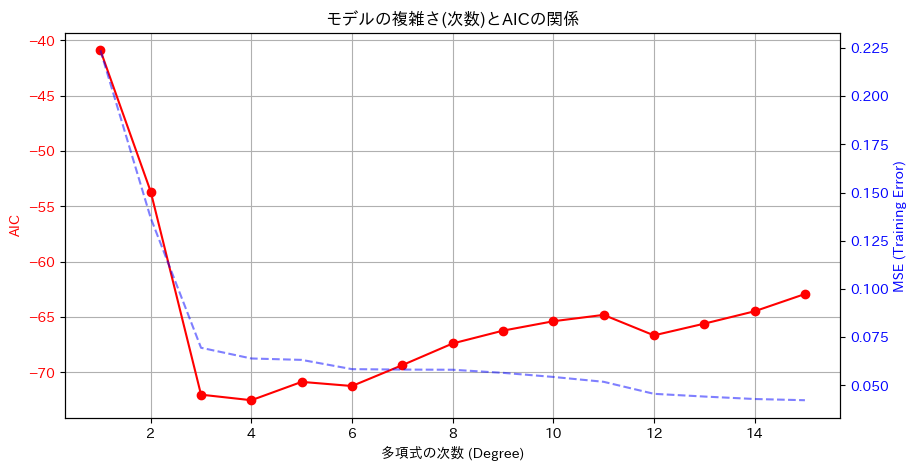

In [3]:
def calculate_aic(n, mse, k):
    """
    AIC = N * ln(MSE) + 2 * k
    N: データ数
    MSE: 平均二乗誤差
    k: パラメータ数
    """
    if mse <= 0: return np.inf
    return n * np.log(mse) + 2 * k

degrees = range(1, 16)
aic_values = []
mse_values = []

for d in degrees:
    model = make_pipeline(PolynomialFeatures(degree=d, include_bias=False), LinearRegression())
    model.fit(X, y)
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y, y_pred)
    k = d + 1 # 係数の数 + 切片
    aic = calculate_aic(len(y), mse, k)
    
    aic_values.append(aic)
    mse_values.append(mse)

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('多項式の次数 (Degree)')
ax1.set_ylabel('AIC', color='red')
ax1.plot(degrees, aic_values, color='red', marker='o', label='AIC')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True)

ax2 = ax1.twinx()  
ax2.set_ylabel('MSE (Training Error)', color='blue')
ax2.plot(degrees, mse_values, color='blue', linestyle='--', alpha=0.5, label='MSE')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('モデルの複雑さ(次数)とAICの関係')
plt.show()

### 結果の解釈
- **MSE (青点線)**: 次数が増えるほど、訓練データへの当てはまりが良くなるため、単調に減少します。
- **AIC (赤実線)**: 最初はMSEの減少に伴って下がりますが、ある点を超えると「パラメータ増加のペナルティ」が勝り、値が上昇に転じます。
- **最適なモデル**: AICが最小となる次数（谷底の部分）が、過学習を避けた適切なモデルである可能性が高いです。